In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import os
import matplotlib.pyplot as plt
import skimage.measure
import scipy.ndimage

from src.datasets import BiosensorDataset, create_datasets
from src.srunet.srunet_model import UNet2, UNet4, UNet8, UNet16
from src.train import train_model
from src.evaluate import evaluate

c:\Users\wittd\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

torch.manual_seed(42)
np.random.seed(42)

data_path = 'C:/onlab_git/Onlab/data_with_centers/'
checkpoint_dir = 'srunet-checkpoints'
train_percent = 0.495
test_percent = 0.30
batch_size = 4
bio_len = 8
upscale_factor = 16
mask_size = 80 * upscale_factor

dilation = 3

train_dataset, val_dataset, test_dataset = create_datasets(data_path, train_percent, bool, test_percent=test_percent, biosensor_length=bio_len, mask_size=mask_size, augment=True, dilation=dilation)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

if upscale_factor == 2:
    model = UNet2(n_channels=bio_len, n_classes=1)
elif upscale_factor == 4:
    model = UNet4(n_channels=bio_len, n_classes=1)
elif upscale_factor == 8:
    model = UNet8(n_channels=bio_len, n_classes=1)
elif upscale_factor == 16:
    model = UNet16(n_channels=bio_len, n_classes=1)

model = model.to(device)

Using device cuda


In [3]:
try:
    train_model(
        model,
        device,
        train_loader,
        val_loader,
        learning_rate=0.01,
        epochs=10,
        checkpoint_dir=checkpoint_dir,
        amp=True,
        wandb_logging=False,
        dilation=dilation
    )
except torch.cuda.OutOfMemoryError:
    torch.cuda.empty_cache()
    print('Detected OutOfMemoryError!')

Starting training:
        Epochs:          10
        Batch size:      4
        Learning rate:   0.01
        Training size:   80
        Validation size: 35
        Device:          cuda
        Mixed Precision: True
        Dilatation:      3
    


Epoch 1/10: 100%|██████████| 80/80 [00:24<00:00,  3.24img/s, loss (batch)=1.09]


Validation Dice score: 0.04581870511174202, Detection rate: 0.025191326530612245
Checkpoint 1 saved!


Epoch 2/10: 100%|██████████| 80/80 [00:24<00:00,  3.29img/s, loss (batch)=0.909]


Validation Dice score: 0.11305027455091476, Detection rate: 0.13839285714285715
Checkpoint 2 saved!


Epoch 3/10: 100%|██████████| 80/80 [00:24<00:00,  3.30img/s, loss (batch)=0.9]  


Validation Dice score: 0.2698095440864563, Detection rate: 0.5044642857142857
Checkpoint 3 saved!


Epoch 4/10: 100%|██████████| 80/80 [00:23<00:00,  3.35img/s, loss (batch)=1.01] 


Validation Dice score: 0.2861766219139099, Detection rate: 0.4107142857142857
Checkpoint 4 saved!


Epoch 5/10: 100%|██████████| 80/80 [00:24<00:00,  3.25img/s, loss (batch)=0.783]


Validation Dice score: 0.20386023819446564, Detection rate: 0.29942602040816324
Checkpoint 5 saved!


Epoch 6/10: 100%|██████████| 80/80 [00:24<00:00,  3.30img/s, loss (batch)=0.877]


Validation Dice score: 0.22746865451335907, Detection rate: 0.3357780612244898
Checkpoint 6 saved!


Epoch 7/10: 100%|██████████| 80/80 [00:24<00:00,  3.32img/s, loss (batch)=0.932]


Validation Dice score: 0.29628077149391174, Detection rate: 0.564094387755102
Checkpoint 7 saved!


Epoch 8/10: 100%|██████████| 80/80 [00:24<00:00,  3.28img/s, loss (batch)=1.02] 


Validation Dice score: 0.2889409363269806, Detection rate: 0.46683673469387754
Checkpoint 8 saved!


Epoch 9/10: 100%|██████████| 80/80 [00:24<00:00,  3.29img/s, loss (batch)=0.748]


Validation Dice score: 0.3065759837627411, Detection rate: 0.5462372448979592
Checkpoint 9 saved!


Epoch 10/10: 100%|██████████| 80/80 [00:24<00:00,  3.27img/s, loss (batch)=0.841]

Validation Dice score: 0.3437580466270447, Detection rate: 0.6492346938775511
Checkpoint 10 saved!


In [4]:
# Load the checkpoint
checkpoint = torch.load("srunet-checkpoints/checkpoint_epoch10.pth")
# Get the learning rate and remove it from the checkpoint
lr = checkpoint.pop('learning_rate')
# Load the state dictionary into the model
model.load_state_dict(checkpoint)
# Move the model to the device
model = model.to(device)

In [5]:
val_dice_score, val_detection_rate = evaluate(model, val_loader, device)
dice_score, detection_rate = evaluate(model, test_loader, device)
print(f'Validation dice score: {val_dice_score}, Detection rate: {val_detection_rate}')
print(f'Test dice score: {dice_score}, Detection rate: {detection_rate}')

Validation dice score: 0.3437580466270447, Detection rate: 0.6492346938775511
Test dice score: 0.32416146993637085, Detection rate: 0.6195763931729386


In [6]:
# Saving the best model for production
# model = UNet(n_channels=8, n_classes=1)
# checkpoint = torch.load("checkpoints/checkpoint_8_4_85.pth")
# lr = checkpoint.pop('learning_rate')
# model.load_state_dict(checkpoint)

model = model.cpu()
torch.jit.script(model).save('saved_models/srunet16_len8.pth')
model = model.to(device)

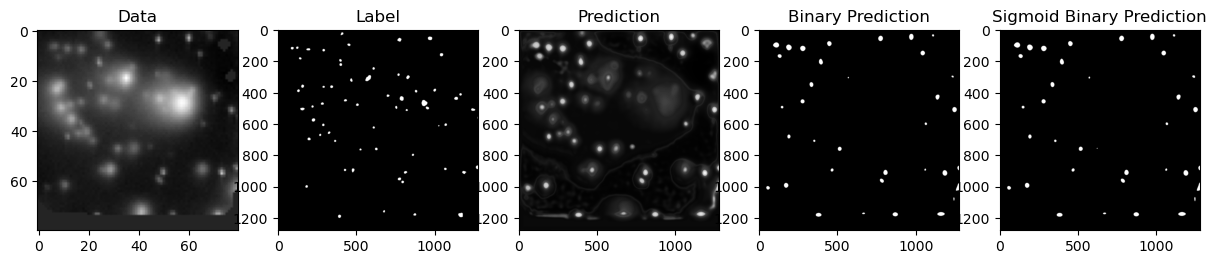

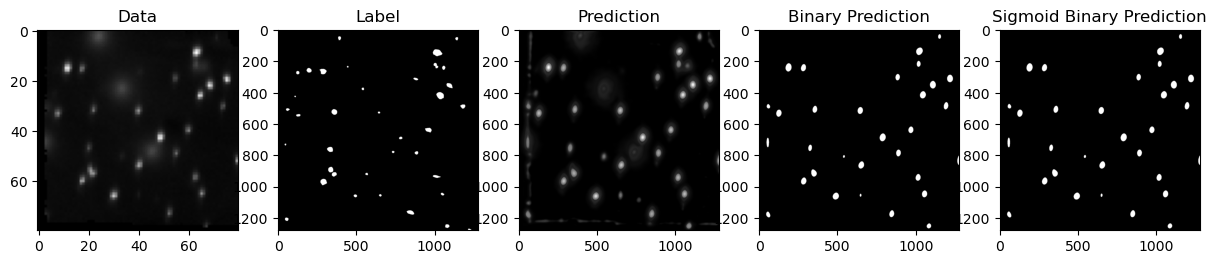

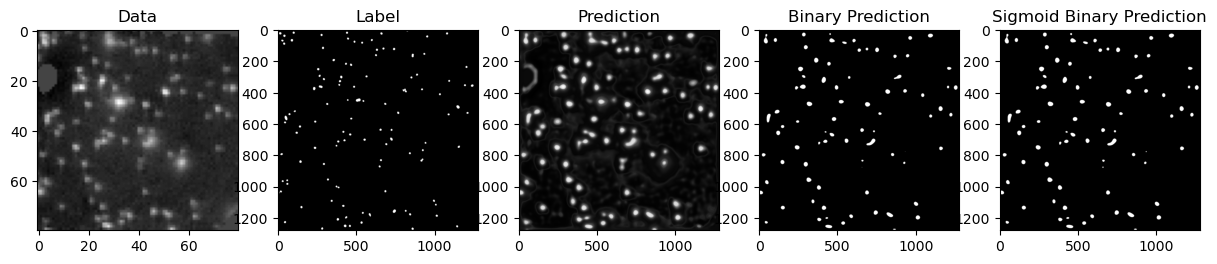

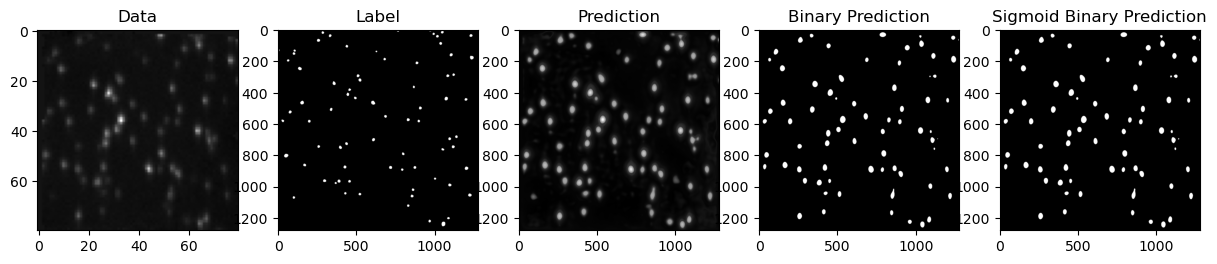

In [7]:
# Load a batch of data and labels
val_loader_iter = iter(val_loader)
data, labels = next(val_loader_iter)
data, labels = next(val_loader_iter)
data, labels = next(val_loader_iter)
# data, labels = next(val_loader_iter)
# data, labels = next(val_loader_iter)
# data, labels = next(val_loader_iter)

# Move the data and labels to the device
data = data.to(device)
labels = labels.to(device)

# Get the predictions
predictions = model(data)
#                                           más??
sigmoid_predictions = (torch.nn.functional.sigmoid(predictions) > 0.5)
sigmoid_predictions = sigmoid_predictions.cpu().detach().numpy()

# Move the predictions and labels to the CPU and convert them to numpy arrays
predictions = predictions.cpu().detach().numpy()
binary_predictions = (predictions > 0.5).astype(np.uint8)


labels = labels.cpu().numpy()

# Plot the data, the labels, and the predictions
for i in range(len(data)):
    plt.figure(figsize=(15, 50))
    
    plt.subplot(1, 5, 1)
    plt.imshow(data[i].cpu().numpy()[-1], cmap='gray')
    plt.title('Data')
    
    plt.subplot(1, 5, 2)
    plt.imshow(np.squeeze(labels[i]), cmap='gray')
    plt.title('Label')
    
    plt.subplot(1, 5, 3)
    plt.imshow(np.squeeze(predictions[i]), cmap='gray')
    plt.title('Prediction')

    plt.subplot(1, 5, 4)
    plt.imshow(np.squeeze(binary_predictions[i]), cmap='gray')
    plt.title('Binary Prediction')
    
    plt.subplot(1, 5, 5)
    plt.imshow(np.squeeze(sigmoid_predictions[i]), cmap='gray')
    plt.title('Sigmoid Binary Prediction')

    plt.show()

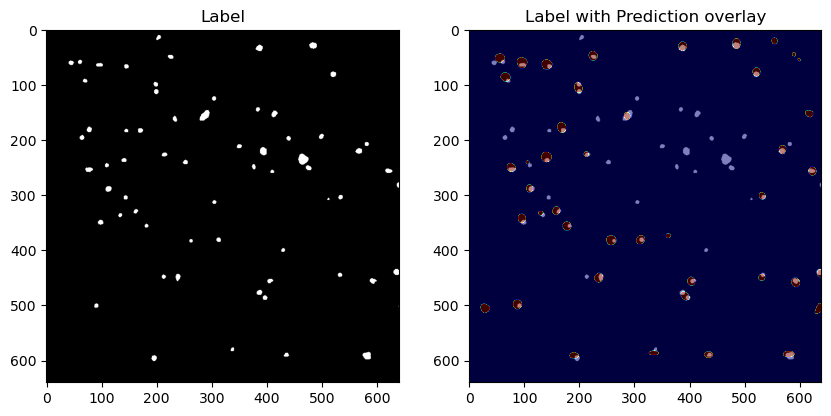

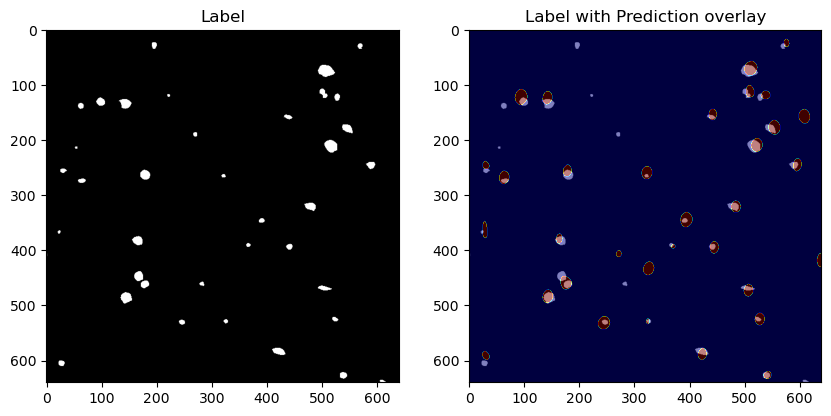

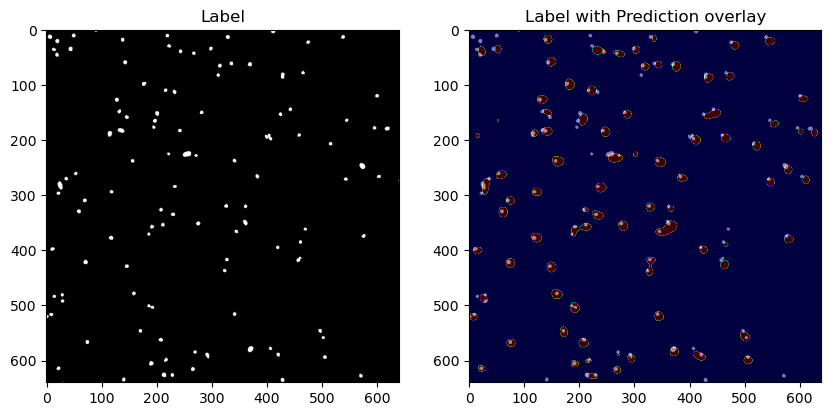

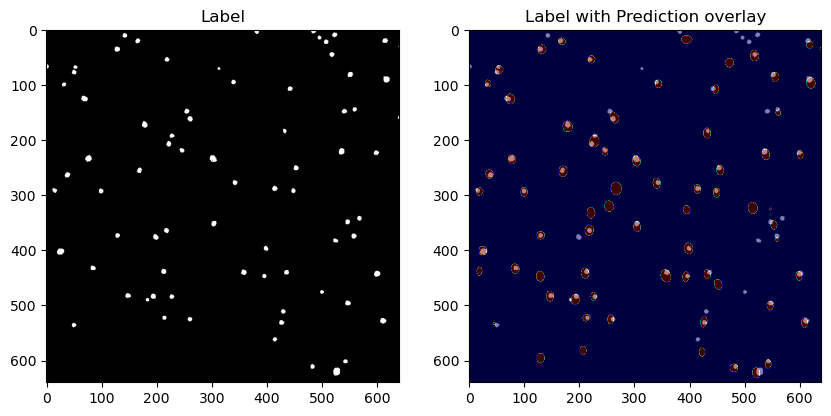

In [28]:
# Plot the label and the prediction
for i in range(len(labels)):
    plt.figure(figsize=(10, 10))
    
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(labels[i]), cmap='gray')
    plt.title('Label')
    
    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(labels[i]), cmap='gray')
    plt.imshow(np.squeeze(binary_predictions[i]), cmap='jet', alpha=0.5)
    plt.title('Label with Prediction overlay')
    
    plt.show()

In [7]:
def cell_detection_skimage(model, val_loader, device, threshold=0.5):
    model.eval()  # Set the model to evaluation mode

    total_cells = 0
    detected_cells = 0

    with torch.no_grad():  # Disable gradient calculation
        for data, labels in val_loader:
            # Move the data and labels to the device
            data = data.to(device)
            labels = labels.to(device)

            # Get the predictions
            predictions = model(data)

            # Move the predictions and labels to the CPU and convert them to numpy arrays
            predictions = predictions.cpu().detach().numpy()
            binary_predictions = (predictions > threshold).astype(np.uint8)

            labels = labels.cpu().numpy()

            for i in range(len(data)):
                # Label the binary prediction and count the number of cells
                _, num_cells_pred = skimage.measure.label(binary_predictions[i], return_num=True, connectivity=2)
                _, num_cells_label = skimage.measure.label(labels[i], return_num=True, connectivity=2)

                total_cells += num_cells_label
                detected_cells += num_cells_pred

    cell_detection_rate = detected_cells / total_cells if total_cells > 0 else 0

    return cell_detection_rate, total_cells, detected_cells

In [8]:
def cell_detection_scipy(model, val_loader, device, threshold=0.5):
    model.eval()  # Set the model to evaluation mode

    total_cells = 0
    detected_cells = 0

    with torch.no_grad():  # Disable gradient calculation
        for data, labels in val_loader:
            # Move the data and labels to the device
            data = data.to(device)
            labels = labels.to(device)

            # Get the predictions
            predictions = model(data)

            # Move the predictions and labels to the CPU and convert them to numpy arrays
            predictions = predictions.cpu().detach().numpy()
            binary_predictions = (predictions > threshold).astype(np.uint8)

            labels = labels.cpu().numpy()

            structure = np.ones((3, 3))

            for i in range(len(data)):
                # Label the binary prediction and count the number of cells
                _, num_cells_pred = scipy.ndimage.label(np.squeeze(binary_predictions[i]), structure=structure)
                _, num_cells_label = scipy.ndimage.label(labels[i], structure=structure)

                total_cells += num_cells_label
                detected_cells += num_cells_pred

    cell_detection_rate = detected_cells / total_cells if total_cells > 0 else 0

    return cell_detection_rate, total_cells, detected_cells

In [9]:
def pos_pixels(model, val_loader, device, threshold=0.5):
    model.eval()  # Set the model to evaluation mode

    total_cells = 0
    detected_cells = 0

    with torch.no_grad():  # Disable gradient calculation
        for data, labels in val_loader:
            # Move the data and labels to the device
            data = data.to(device)
            labels = labels.to(device)

            # Get the predictions
            predictions = model(data)

            # Move the predictions and labels to the CPU and convert them to numpy arrays
            predictions = predictions.cpu().detach().numpy()
            binary_predictions = (predictions > threshold).astype(np.uint8)

            labels = labels.cpu().numpy()

            total_cells += np.sum(labels)
            detected_cells += np.sum(binary_predictions)

    return total_cells, detected_cells

In [10]:
label, detected = pos_pixels(model, val_loader, device, threshold=0.5)
print(label, detected)

444260 428421


In [23]:
cell_detection_rate, total, detected = cell_detection_skimage(model, val_loader, device)
print(f'Cell detection rate: {cell_detection_rate}, total cells: {total}, detected cells: {detected}')

Cell detection rate: 0.2503092783505155, total cells: 4850, detected cells: 1214


In [12]:
cell_detection_rate, total, detected = cell_detection_scipy(model, val_loader, device)
print(f'Cell detection rate: {cell_detection_rate}, total cells: {total}, detected cells: {detected}')

Cell detection rate: 0.6216494845360825, total cells: 4850, detected cells: 3015
